In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, mean_squared_error
import matplotlib.pyplot as plt
import time
import tqdm
import math
import random

In [3]:
df = pd.read_csv('datasets/tabular-playground-series-aug-2021/train.csv')

In [4]:
target_col = 'loss'

In [5]:
df.describe()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,124999.500000,0.511213,51.378476,0.107155,0.050010,3595.133426,8.205953,164.508753,0.375533,16.669745,...,4856.812768,22.579100,2.030554,0.079692,1.555097,2.417556,0.537484,1.576900,8.048805,6.813920
std,72168.927986,0.307884,42.396636,1.322200,0.792368,6072.401061,5.475723,183.335563,0.813597,99.758709,...,8501.609009,14.849390,0.900211,0.587780,9.253785,0.892563,0.226589,0.646306,5.647368,7.940179
min,0.000000,-0.069273,-17.000000,-7.895580,-1.475560,-7589.280000,-3.291050,-40.967200,-4.143080,-502.813000,...,-12695.700000,-4.059170,0.057800,-1.998800,-24.686300,-1.131980,0.005249,-0.646967,-0.842397,0.000000
25%,62499.750000,0.251287,18.000000,-0.611172,-0.719418,163.864750,4.110127,27.894900,-0.026245,-17.392025,...,73.203100,11.525450,1.471650,-0.408975,-4.004925,1.906718,0.359646,1.215810,3.732800,1.000000
50%,124999.500000,0.514962,41.000000,0.253815,0.004099,943.000500,7.472445,91.005250,0.619862,8.714945,...,1060.025000,19.993200,1.660830,0.215710,0.759942,2.340430,0.531348,1.451285,7.182205,4.000000
75%,187499.250000,0.777322,75.000000,0.759249,0.765456,4115.355000,11.030950,240.843750,0.933855,55.407625,...,5572.982500,32.271625,2.320085,0.503134,6.202503,2.910020,0.709807,1.901632,10.998550,10.000000
max,249999.000000,1.072070,273.000000,9.768590,1.680190,37847.500000,35.078000,947.143000,4.010380,465.956000,...,54334.600000,79.912400,5.403020,1.944190,42.890400,5.576040,1.105400,4.492620,34.019200,42.000000


In [6]:
df[target_col].value_counts()

0     60144
2     22225
1     22069
3     15902
4     13371
5     12458
6     10697
7      8894
8      8264
9      7435
10     7242
11     6572
12     5718
13     4828
14     4182
15     3671
16     3580
17     3420
18     3354
19     3079
20     2878
21     2478
22     2203
23     1875
24     1722
25     1457
26     1385
27     1284
28     1129
29     1096
30     1057
31      899
32      852
33      663
34      570
35      485
36      361
37      266
38      135
39       62
40       24
41       11
42        3
Name: loss, dtype: int64

In [7]:
df[target_col].value_counts()/len(df)

0     0.240576
2     0.088900
1     0.088276
3     0.063608
4     0.053484
5     0.049832
6     0.042788
7     0.035576
8     0.033056
9     0.029740
10    0.028968
11    0.026288
12    0.022872
13    0.019312
14    0.016728
15    0.014684
16    0.014320
17    0.013680
18    0.013416
19    0.012316
20    0.011512
21    0.009912
22    0.008812
23    0.007500
24    0.006888
25    0.005828
26    0.005540
27    0.005136
28    0.004516
29    0.004384
30    0.004228
31    0.003596
32    0.003408
33    0.002652
34    0.002280
35    0.001940
36    0.001444
37    0.001064
38    0.000540
39    0.000248
40    0.000096
41    0.000044
42    0.000012
Name: loss, dtype: float64

# Try different train size and check results

In [8]:
from src.dataset import Dataset

In [9]:
from src.sampling_methods.sampling_methods import RandomSample, XgboostSubsample, TreeSample, CostumeSample, sampling_utils

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col], test_size=0.2, shuffle = True)

In [11]:
dataset = Dataset(df, X_train, y_train, X_test, y_test, target_col, mean_squared_error)

### regular methods

In [22]:
random_sample = RandomSample('random', model=xgb.XGBRegressor(random_state=random.randint(1, 30)))
xgboost_sample = XgboostSubsample('xgb_subsample', model=sampling_utils.REGRESSION)
#tree_sample = TreeSample('tree', model=xgb.XGBRegressor(random_state=random.randint(1, 30)))

### imblearn methods

In [14]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from functools import partial

In [15]:
def cluster_sample_function(dataset, p):
    values = list(dataset.y_train.unique())
    cnn = ClusterCentroids(estimator=MiniBatchKMeans(n_clusters=100),
                           sampling_strategy={v: math.ceil(p * len(dataset.y_train[dataset.y_train == v])) for v in values})
    X_real_train, y_real_train = cnn.fit_resample(X_train, y_train)
    return X_real_train, y_real_train

In [15]:
cluster = CostumeSample('cluster', cluster_sample_function)

In [16]:
def cnn_sample_function(dataset, p):
    cnn = CondensedNearestNeighbour()
    X_real_train, y_real_train = cnn.fit_resample(dataset.X_train, dataset.y_train)
    return X_real_train, y_real_train

In [17]:
cnn = CostumeSample('cnn', cnn_sample_function)

## Test

In [25]:
random_sample.test_sample_method(dataset, trials_number=5, print_results=True)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

(70.03946683501475, 5.869602918624878, 0.05)
(70.22549115439166, 6.141949415206909, 0.05)
(70.6714516653919, 5.994303226470947, 0.05)
(70.61918165746145, 5.80810546875, 0.05)


 17%|██████████████                                                                      | 1/6 [00:29<02:29, 29.93s/it]

(69.81032710949893, 6.113120794296265, 0.05)
(67.88988692037829, 11.126328468322754, 0.099995)
(68.23262191907969, 11.31267237663269, 0.099995)
(68.11941086226, 11.386160850524902, 0.099995)
(67.95557610274584, 11.190171957015991, 0.099995)


 33%|████████████████████████████                                                        | 2/6 [01:26<03:01, 45.48s/it]

(68.10040358751702, 11.330857276916504, 0.099995)
(66.0460905555663, 22.287456035614014, 0.2)
(65.82438833961416, 22.2933566570282, 0.2)
(65.48158108484101, 22.30260729789734, 0.2)
(65.7341117922822, 22.421091556549072, 0.2)


 50%|██████████████████████████████████████████                                          | 3/6 [03:17<03:46, 75.62s/it]

(65.99532862139807, 22.172141313552856, 0.2)
(64.57991625826268, 33.04957318305969, 0.300015)
(64.47788769529319, 32.95190739631653, 0.300015)
(64.83490325163334, 32.89459300041199, 0.300015)
(64.65750272642859, 33.025147676467896, 0.300015)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [06:02<03:41, 110.90s/it]

(64.94611849417929, 33.02686858177185, 0.300015)
(63.942509163323265, 43.877227544784546, 0.399995)
(63.849776913351945, 43.83343434333801, 0.399995)
(64.1155218404883, 43.62721037864685, 0.399995)
(64.03886350638598, 43.53937864303589, 0.399995)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [09:41<02:29, 149.86s/it]

(63.85513838467239, 43.99987292289734, 0.399995)
(63.01297184817097, 80.37196135520935, 0.750005)
(62.89799486279946, 79.92872071266174, 0.750005)
(63.03009038264913, 80.27171802520752, 0.750005)
(62.8974156274063, 79.87127351760864, 0.750005)


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [16:22<00:00, 163.72s/it]

(63.067153940794626, 80.09218144416809, 0.750005)


In [24]:
xgboost_sample.test_sample_method(dataset, trials_number=5, print_results=True, update_pcts=False)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

(82.07955832455215, 25.763507843017578)
(80.9756917262584, 26.111470699310303)
(79.25402912617729, 26.218371152877808)
(79.86088910786162, 25.490233182907104)


 17%|█████████████▊                                                                     | 1/6 [02:09<10:48, 129.69s/it]

(82.49310678420771, 26.099855184555054)
(71.60921751435066, 30.79564619064331)
(72.33595571846465, 31.73952579498291)
(71.60921751435066, 30.923131227493286)
(71.60921751435066, 31.246201992034912)


 33%|███████████████████████████▋                                                       | 2/6 [04:45<09:41, 145.34s/it]

(72.228363338047, 31.58291482925415)
(66.7656071182255, 41.844233989715576)
(67.31896783910719, 41.66696548461914)
(67.25403852842977, 41.52030682563782)
(67.49302651224303, 41.60302734375)


 50%|█████████████████████████████████████████▌                                         | 3/6 [08:14<08:41, 174.00s/it]

(67.14853058105525, 41.465882539749146)
(65.26319925341807, 55.79504942893982)
(65.067032807441, 56.136035680770874)
(65.70833117978363, 53.170390605926514)
(65.40022958892253, 52.88070344924927)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [12:45<07:04, 212.27s/it]

(65.09583002494367, 52.952362298965454)
(64.59053636337278, 64.18229031562805)
(64.5410056027714, 64.64832282066345)
(64.50994298447107, 65.19376349449158)
(64.31884466326647, 63.380000829696655)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [18:06<04:11, 251.48s/it]

(64.17012466639605, 63.57720756530762)
(63.19104789466855, 91.3850998878479)
(62.905972421041675, 91.64374279975891)
(63.01268664668074, 90.49527835845947)
(63.08715800954801, 91.59588408470154)


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [25:41<00:00, 256.92s/it]

(63.08715800954801, 90.36712551116943)


In [20]:
tree_sample.test_sample_method(dataset, trials_number=2, print_results=True)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

(0.7798742138364779, 11.708677053451538, 0.05091619302596063)


  0%|                                                                                            | 0/6 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
cluster.test_sample_method(dataset, print_results=True, trials_number=2, percents=sampling_utils.DEFAULT_PCT[:1])

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(self.pct, self.scores, yerr=self.stds, fmt='bo', color=color, label=self.name, capsize=4)


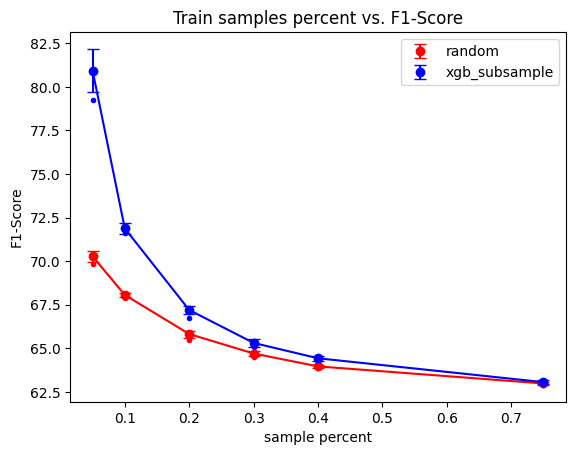

In [28]:
random_sample.print_scores()
xgboost_sample.print_scores('b')
#tree_sample.print_scores('g')
#cluster.print_scores('purple')

plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')

plt.legend()

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(self.pct, self.times, 'bo', color=color, label=self.name)


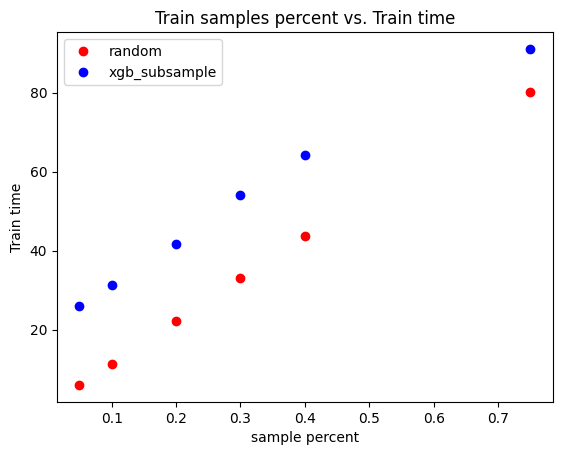

In [29]:
random_sample.print_times()
xgboost_sample.print_times('b')
#tree_sample.print_times('g')
#cluster.print_times('purple')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')

plt.legend()

In [ ]:
random_sample.print_times()
xgboost_sample.print_times('b')
tree_sample.print_times('g')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')
plt.legend()

## Test small ps

In [ ]:
small_pct = [0.001, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.05, 0.1]

In [ ]:
random_small = RandomSample('random')
xgboost_small = XgboostSubsample('xgb_subsample')
tree_small = TreeSample('tree')

In [ ]:
cluster_small = CostumeSample('cluster', cluster_sample_function)

In [ ]:
random_small.test_sample_method(dataset, trials_number=2, print_results=True, percents=small_pct)

In [ ]:
xgboost_small.test_sample_method(dataset, trials_number=2, print_results=True, update_pcts=False, percents=small_pct)

In [ ]:
tree_small.test_sample_method(dataset, trials_number=2, print_results=True, percents=small_pct)

In [ ]:
cluster_small.test_sample_method(dataset, print_results=True, trials_number=2, percents=small_pct)

In [ ]:
random_small.print_scores()
xgboost_small.print_scores('b')
tree_small.print_scores('g')
cluster_small.print_scores('purple')

plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')

plt.legend()

In [ ]:
random_small.print_times()
xgboost_small.print_times('b')
tree_small.print_times('g')
cluster_small.print_times('purple')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')

plt.legend()

## Visualize decision tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [26]:
singel_tree_model = DecisionTreeClassifier(min_weight_fraction_leaf=0.05, class_weight='balanced')

In [27]:
s = time.time()
singel_tree_model.fit(X_train, y_train)
time.time() - s

5.771573543548584

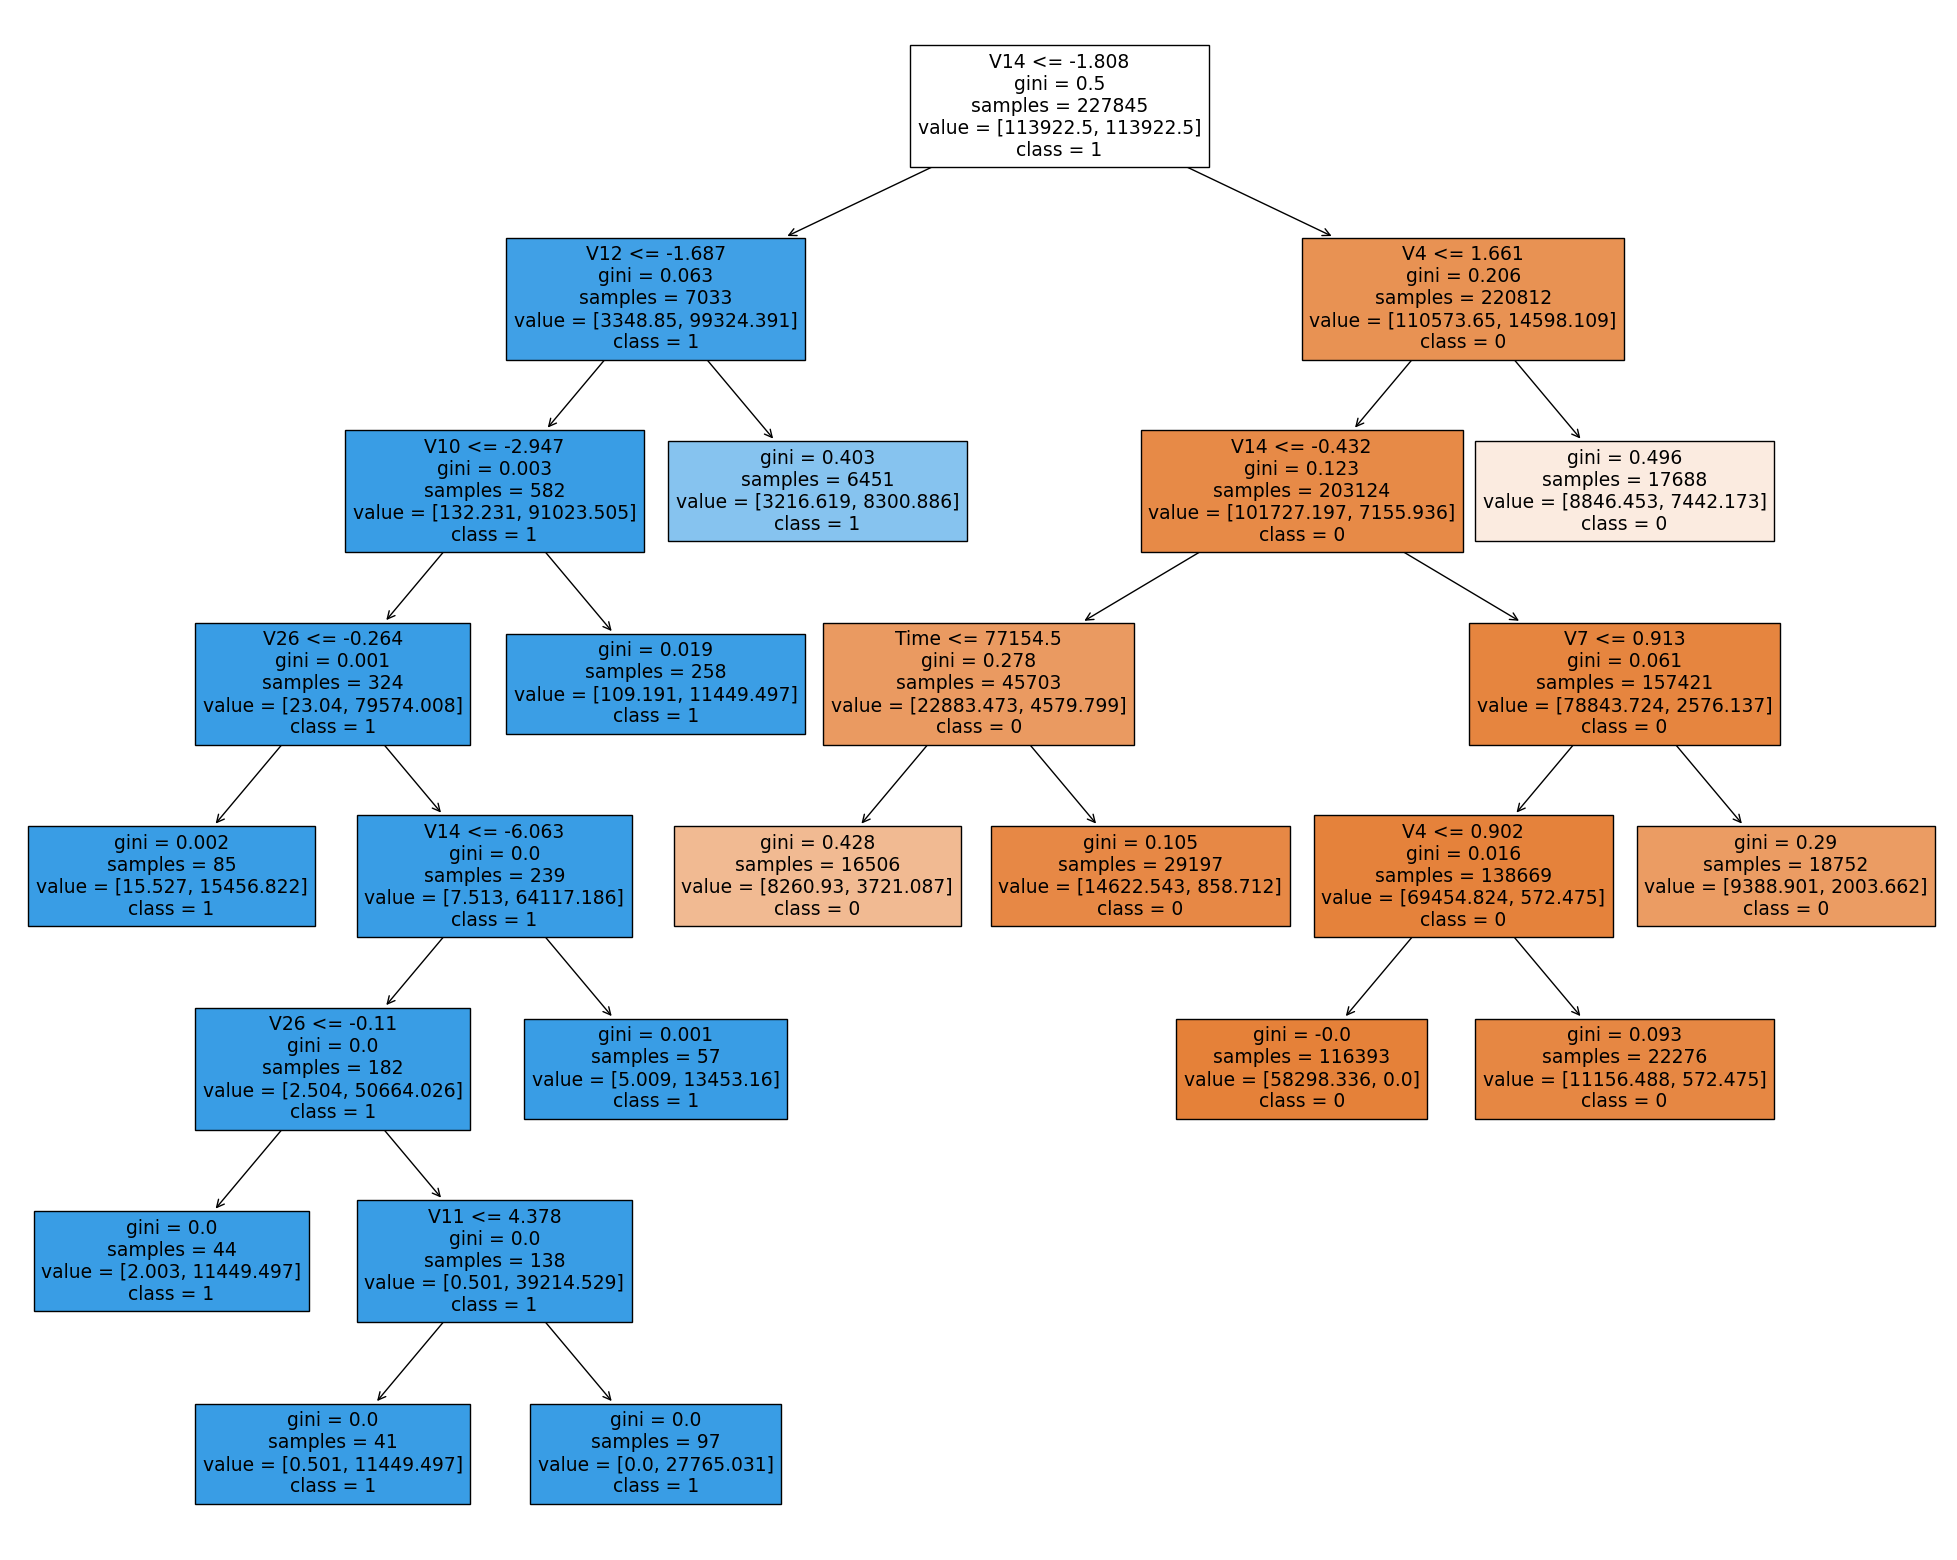

In [28]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(singel_tree_model, 
                   feature_names=X_train.columns,  
                   class_names=['0','1'],
                   filled=True,
                   )

## XGBoost paths

In [12]:
from src.gbdt_model_paths.model_path import ModelPath

In [13]:
model_path = ModelPath(xgb.XGBRegressor(max_depth=3), dataset)

C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.X_diff[f'diff_{n}'] = round(self.X_diff[f'pred_{n}'] - self.X_diff[f'pred_{n - 1}'], 5)
C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.X_diff[f'pred_{n}'] = model.predict(dataset.X_train, iteration_range=(0, n+1), output_margin=True)
C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:16: PerformanceWarnin

### EDA

In [14]:
#for num_trees in range(0, model_path.num_trees, 5):
for num_trees in range(0, 31, 5):
    print(f'trees number: {num_trees}')
    model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(num_trees + 1)]))
    print('\n')

trees number: 0


C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


1: 0, 0: 0, all: 8
part of groups: 0.0
part of examples: 0.0


trees number: 5
1: 180, 0: 2782, all: 4433
part of groups: 0.6681705391382811
part of examples: 0.04047


trees number: 10
1: 2550, 0: 35932, all: 44457
part of groups: 0.8656004678678273
part of examples: 0.33925


trees number: 15
1: 11976, 0: 137074, all: 153574
part of groups: 0.970541888600935
part of examples: 0.87423


trees number: 20
1: 16878, 0: 177271, all: 194859
part of groups: 0.9963563397123048
part of examples: 0.99067


trees number: 25
1: 17624, 0: 182336, all: 199966
part of groups: 0.9999699948991329
part of examples: 0.999935


trees number: 30
1: 17630, 0: 182368, all: 199998
part of groups: 1.0
part of examples: 1.0




(array([20122., 11311.,  2811.,   262.]),
 array([   1.,    2.,   10.,  100., 1000.]),
 <BarContainer object of 4 artists>)

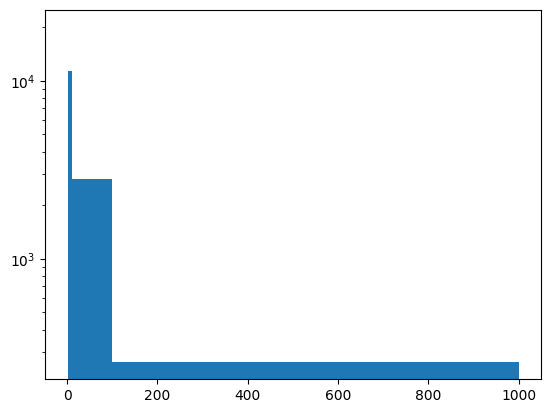

In [17]:
grouped_df = model_path.X_diff.groupby([f'diff_{i}' for i in range(10)]).count()[[target_col]]
plt.hist(grouped_df[target_col], log=True, bins=[1,2,10,100,1000])

In [18]:
ratios, counts = model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(10)]), print_stats=False)
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.68545

In [19]:
ratios, counts = model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(10)]), print_stats=False)
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.68545

(array([31433.,  1526.,   528.,   252.,   179.,   108.,    75.,    70.,
           41.,    32.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

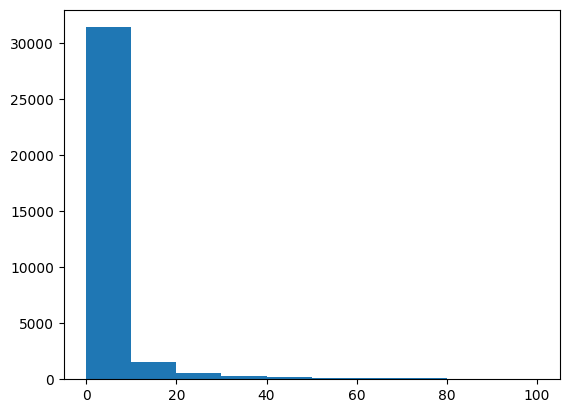

In [20]:
plt.hist(counts, range=(0, 100))

(array([2.8552e+04, 1.6650e+03, 9.0100e+02, 5.8200e+02, 6.6000e+01,
        8.4600e+02, 4.2000e+01, 5.0000e+00, 0.0000e+00, 1.8540e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

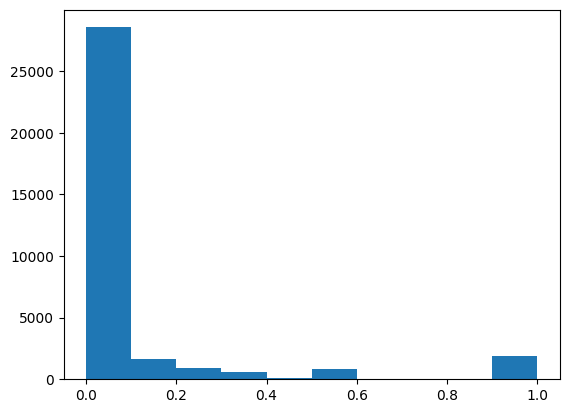

In [21]:
plt.hist(ratios)

In [22]:
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.68545

In [23]:
len(counts) / sum(counts)

0.172565

### Sample by leafs combinations

In [14]:
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'k', 'pink'] 

In [15]:
from src.sampling_methods.sampling_methods import XgboostPathSample

In [26]:
experimets = [XgboostPathSample(f'{i} trees', model_path, i, model=xgb.XGBRegressor(random_state=random.randint(1, 30)), use_target=False) for i in [1, 2, 3, 5, 7, 10, 13, 20]]

In [27]:
for e in experimets:
    print ('#######################################')
    e.test_sample_method(dataset, print_results=True, trials_number=5, percents=sampling_utils.DEFAULT_PCT[:-2])

#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(71.8883121043581, 8.693607568740845, 0.050015)
(71.91643211845012, 8.311874628067017, 0.050015)
(71.90747503947586, 8.463197946548462, 0.050015)
(70.84491528889504, 8.33351755142212, 0.050015)


 25%|█████████████████████                                                               | 1/4 [00:42<02:06, 42.25s/it]

(72.97212075191881, 8.425909519195557, 0.050015)
(68.68966699514175, 13.772900104522705, 0.100015)
(69.33114343768943, 14.72558045387268, 0.100015)
(69.01160421157246, 13.974919557571411, 0.100015)
(69.40331045459573, 14.110927104949951, 0.100015)


 50%|██████████████████████████████████████████                                          | 2/4 [01:53<01:58, 59.13s/it]

(68.71924598556583, 14.32847547531128, 0.100015)
(66.12729931042082, 25.430904626846313, 0.200015)
(65.57300760680451, 25.47382640838623, 0.200015)
(65.45312577370723, 25.594714641571045, 0.200015)
(65.88102527652057, 24.84269428253174, 0.200015)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:59<01:29, 89.64s/it]

(65.7373060123658, 24.55534029006958, 0.200015)
(64.78316031428425, 35.406604528427124, 0.30002)
(64.83072715207692, 35.558836460113525, 0.30002)
(64.78372472342438, 35.5301513671875, 0.30002)
(64.84032951635916, 35.386210918426514, 0.30002)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [06:56<00:00, 104.13s/it]


(64.63029162953399, 35.40141797065735, 0.30002)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(71.97018157205996, 8.784492015838623, 0.05011)
(72.20673826880123, 8.437340259552002, 0.05011)
(72.48121071257904, 8.726197004318237, 0.05011)
(70.54347027089973, 8.537461042404175, 0.05011)


 25%|█████████████████████                                                               | 1/4 [00:43<02:09, 43.03s/it]

(71.26324795816971, 8.502330303192139, 0.05011)
(68.90758266040308, 14.171013593673706, 0.10011)
(68.79887753434757, 13.896054029464722, 0.10011)
(68.4762307174014, 13.716515064239502, 0.10011)
(69.14760287287415, 13.579961776733398, 0.10011)


 50%|██████████████████████████████████████████                                          | 2/4 [01:52<01:56, 58.46s/it]

(68.82620720747806, 13.829270124435425, 0.10011)
(66.09974695569214, 25.251652002334595, 0.20009)
(65.8913315661942, 24.49549889564514, 0.20009)
(65.96140836448318, 24.62755513191223, 0.20009)
(65.84759137823121, 25.319849014282227, 0.20009)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:56<01:28, 88.63s/it]

(65.70912844237169, 24.757404565811157, 0.20009)
(64.87979343147467, 35.909117698669434, 0.300105)
(64.63097785374912, 35.59880781173706, 0.300105)
(64.60245856734392, 35.9660325050354, 0.300105)
(65.0218658176737, 35.72653031349182, 0.300105)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [06:55<00:00, 103.93s/it]


(64.65231394897766, 35.58508658409119, 0.300105)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(72.02122648870947, 8.786731481552124, 0.05044)
(72.85623362472212, 8.453610897064209, 0.05044)
(71.89489078379326, 8.55355453491211, 0.05044)
(72.52667799732853, 8.518714666366577, 0.05044)


 25%|█████████████████████                                                               | 1/4 [00:43<02:09, 43.06s/it]

(71.9844381708436, 8.696513175964355, 0.05044)
(68.8375382829815, 14.019288778305054, 0.100405)
(68.10635862727094, 14.012091398239136, 0.100405)
(68.80766894033906, 13.824219465255737, 0.100405)
(68.88490449021853, 13.791057586669922, 0.100405)


 50%|██████████████████████████████████████████                                          | 2/4 [01:52<01:57, 58.65s/it]

(68.70636972502645, 13.844951152801514, 0.100405)
(65.94029555783769, 24.969173431396484, 0.200335)
(65.74874536322875, 25.303064584732056, 0.200335)
(65.85990668122456, 25.291603565216064, 0.200335)
(66.24672105535994, 24.747716188430786, 0.200335)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:57<01:29, 89.02s/it]

(66.31382348833736, 24.761738300323486, 0.200335)
(64.47094441334437, 35.50376868247986, 0.300385)
(64.78975862931993, 35.58703827857971, 0.300385)
(64.65059568471376, 35.468364238739014, 0.300385)
(64.91147939912759, 35.59064602851868, 0.300385)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [06:56<00:00, 104.01s/it]


(64.80179554245666, 36.00231909751892, 0.300385)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(71.2726045329517, 9.507142066955566, 0.05404)
(71.7513519415253, 9.530457973480225, 0.05404)
(71.9698355884446, 11.327760696411133, 0.05404)
(70.91126471571316, 9.302612781524658, 0.05404)


 25%|█████████████████████                                                               | 1/4 [00:48<02:26, 48.84s/it]

(71.50095196113746, 9.13066291809082, 0.05404)
(68.90036527138173, 14.466586828231812, 0.1035)
(68.49977967323228, 14.543503761291504, 0.1035)
(68.54213095134017, 14.564018726348877, 0.1035)
(68.64265550796853, 14.531678438186646, 0.1035)


 50%|██████████████████████████████████████████                                          | 2/4 [02:01<02:05, 62.83s/it]

(68.73194525174847, 14.459127426147461, 0.1035)
(66.32864173448826, 25.633869171142578, 0.20288)
(65.84976556603331, 25.16681456565857, 0.20288)
(65.86604294881978, 25.220558166503906, 0.20288)
(66.18897850195576, 25.40601420402527, 0.20288)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [04:08<01:32, 92.13s/it]

(66.28335970159277, 25.500744342803955, 0.20288)
(64.91264116630822, 36.03648495674133, 0.30279)
(64.89909511958278, 36.27518963813782, 0.30279)
(64.43241533168012, 35.970277309417725, 0.30279)
(64.69105359285905, 36.18208718299866, 0.30279)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:09<00:00, 107.29s/it]


(64.54541644636468, 36.14445447921753, 0.30279)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(68.55111369465367, 14.73966908454895, 0.08415)
(69.11119689074783, 14.62193775177002, 0.08415)
(69.16573486255095, 14.585558414459229, 0.08415)
(68.59598472751092, 14.62981128692627, 0.08415)


 25%|█████████████████████                                                               | 1/4 [01:13<03:39, 73.19s/it]

(68.73200390752746, 14.566945314407349, 0.08415)
(67.47390453951161, 19.667781352996826, 0.13043)
(67.15363881112846, 19.502605199813843, 0.13043)
(67.02045516611896, 19.53775668144226, 0.13043)
(67.3333893930459, 19.394204139709473, 0.13043)


 50%|██████████████████████████████████████████                                          | 2/4 [02:50<02:55, 87.66s/it]

(66.74796650265814, 19.61913299560547, 0.13043)
(65.52734797599602, 29.954737424850464, 0.22513)
(65.61763215858736, 29.961961030960083, 0.22513)
(65.49613783750856, 29.746863842010498, 0.22513)
(65.52099628083674, 29.660375595092773, 0.22513)


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [05:20<01:55, 115.84s/it]

(65.41014999506174, 29.96025037765503, 0.22513)
(64.3616082166089, 40.29246950149536, 0.32311)
(64.78809695038366, 40.54147124290466, 0.32311)
(64.57896641186376, 40.51694631576538, 0.32311)
(64.52972679399596, 40.14935922622681, 0.32311)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:43<00:00, 130.88s/it]


(64.45420772104784, 41.55593204498291, 0.32311)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(64.72766006005351, 57.561787843704224, 0.300315)
(64.59348513670324, 56.49975633621216, 0.300315)
(64.44967916043025, 56.56836009025574, 0.300315)
(64.69004567589141, 56.509833335876465, 0.300315)


 25%|████████████████████▊                                                              | 1/4 [04:43<14:10, 283.65s/it]

(64.77745225963386, 56.37567591667175, 0.300315)
(64.20546178685319, 59.413779735565186, 0.32684)
(64.42123289302451, 58.45970821380615, 0.32684)
(64.29825313654364, 58.9517080783844, 0.32684)
(64.46847653759875, 58.82975769042969, 0.32684)


 50%|█████████████████████████████████████████▌                                         | 2/4 [09:38<09:40, 290.06s/it]

(64.38918362773255, 58.75941205024719, 0.32684)
(64.12005556986891, 65.13934516906738, 0.39031)
(63.93731178604302, 65.27415060997009, 0.39031)
(63.97843684474281, 65.78636431694031, 0.39031)
(64.2394079274464, 65.29397630691528, 0.39031)


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [15:05<05:06, 306.89s/it]

(63.957959552461624, 65.26743412017822, 0.39031)
(63.81776276585709, 72.84644842147827, 0.468275)
(63.484060125819454, 73.52176856994629, 0.468275)
(63.51247357716592, 73.11564469337463, 0.468275)
(63.65957134259514, 74.0141396522522, 0.468275)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [21:11<00:00, 317.98s/it]


(63.39224922002599, 73.13653469085693, 0.468275)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(63.04311938438138, 139.63772010803223, 0.605745)
(63.11138875446425, 137.7761516571045, 0.605745)
(63.263020061203584, 137.19665908813477, 0.605745)
(63.15185074999731, 135.35894513130188, 0.605745)


 25%|████████████████████▊                                                              | 1/4 [11:27<34:21, 687.27s/it]

(63.172664523893474, 137.1263132095337, 0.605745)
(63.1009132274723, 135.40745735168457, 0.614505)
(62.93830422874829, 137.01336860656738, 0.614505)
(63.10876051458727, 136.88880228996277, 0.614505)
(63.20087202702706, 137.07282614707947, 0.614505)


 50%|█████████████████████████████████████████▌                                         | 2/4 [22:52<22:51, 685.93s/it]

(63.17496209525974, 138.43595957756042, 0.614505)
(63.071226846861876, 138.97340607643127, 0.6413)
(63.20613999943489, 133.63960576057434, 0.6413)
(62.92723394129821, 131.8475422859192, 0.6413)
(63.17947327556448, 132.24863004684448, 0.6413)


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [34:01<11:18, 678.34s/it]

(62.99750813035751, 132.43433165550232, 0.6413)
(62.993837532921454, 136.2800488471985, 0.68288)
(63.00348883494718, 136.484876871109, 0.68288)
(63.011361744331374, 136.30778455734253, 0.68288)
(63.23059336651476, 135.28363823890686, 0.68288)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [45:21<00:00, 680.38s/it]


(63.09052055768484, 135.3939995765686, 0.68288)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(62.535656975294465, 238.79280161857605, 0.990275)
(62.494322215269875, 237.05725479125977, 0.990275)
(62.50150397666363, 237.11554312705994, 0.990275)
(62.5044590872109, 239.45609855651855, 0.990275)


 25%|████████████████████▌                                                             | 1/4 [19:50<59:30, 1190.14s/it]

(62.57136956821561, 237.45526838302612, 0.990275)
(62.62291533029335, 241.0730700492859, 0.990275)
(62.558627960027486, 240.34370040893555, 0.990275)
(62.42655730141304, 244.1487627029419, 0.990275)
(62.59036808995749, 238.43341088294983, 0.990275)


 50%|█████████████████████████████████████████                                         | 2/4 [39:57<40:00, 1200.14s/it]

(62.628408984501924, 242.89188694953918, 0.990275)
(62.451438372582466, 241.18030786514282, 0.990285)
(62.553894277194814, 243.03779768943787, 0.990285)
(62.46886345454768, 241.9963083267212, 0.990285)
(62.64250216620769, 245.3194077014923, 0.990285)


 75%|████████████████████████████████████████████████████████████                    | 3/4 [1:00:11<20:06, 1206.34s/it]

(62.487262230328184, 241.92405366897583, 0.990285)
(62.7045911469482, 247.33947896957397, 0.990505)
(62.63976020839276, 244.29989743232727, 0.990505)
(62.58750921949055, 246.24790167808533, 0.990505)
(62.66121268107957, 245.22065114974976, 0.990505)


100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:20:40<00:00, 1210.10s/it]

(62.676181249562724, 246.0222887992859, 0.990505)


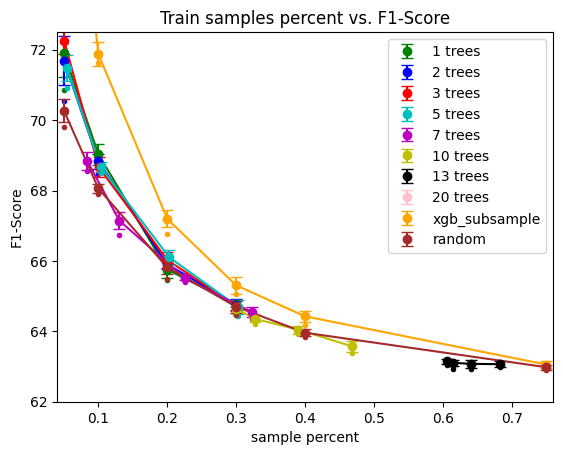

In [40]:
for i, e in enumerate(experimets):
    e.print_scores(colors[i])
xgboost_sample.print_scores('orange')
random_sample.print_scores('brown')
plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')
plt.ylim((62, 72.5))
plt.xlim((0.04,0.76))
plt.legend()

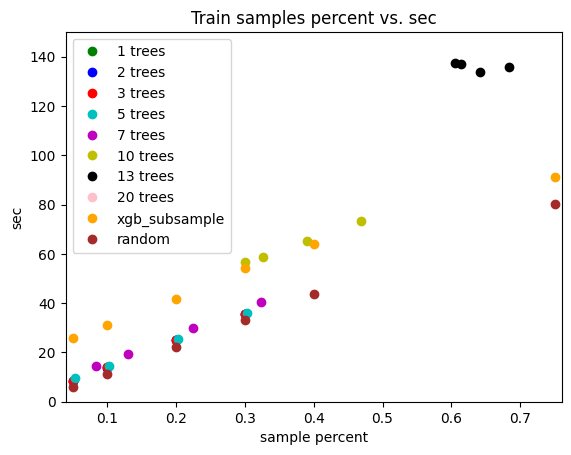

In [46]:
for i, e in enumerate(experimets):
    e.print_times(colors[i])
xgboost_sample.print_times('orange')
random_sample.print_times('brown')
plt.title('Train samples percent vs. sec')
plt.xlabel('sample percent')
plt.ylabel('sec')
plt.xlim((0.04,0.76))
plt.ylim((0, 150))
plt.legend()

In [41]:
e.times

[237.9753932952881, 241.37816619873047, 242.691575050354, 245.82604360580444]

In [ ]:
#%load_ext autoreload
#%autoreload 2